## Version 3 (motion) train and run


In [1]:
import cv2
import mediapipe as mp
import time
from google.protobuf.json_format import MessageToDict
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import utils
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands
from keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, MaxPooling1D,TimeDistributed
from keras.optimizers import Adam
import keras
from tensorflow.keras.models import  save_model,load_model
from keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

### Data Processing

In [2]:
# Load
read_dictionary = np.load('handsignmotion.npy',allow_pickle='TRUE').item()
print(read_dictionary['L']) # displays "world"

[[[[ 5.73653996e-01  5.78611910e-01 -5.11188555e-05]
   [ 5.30954421e-01  5.92438340e-01 -2.59167347e-02]
   [ 4.78140950e-01  5.49021244e-01 -4.39113304e-02]
   ...
   [ 5.87565422e-01  4.41231072e-01 -7.95733556e-02]
   [ 5.85160196e-01  4.88084376e-01 -8.64540040e-02]
   [ 5.82069576e-01  5.06527424e-01 -8.45909119e-02]]

  [[ 5.72732568e-01  5.81182539e-01 -4.79743285e-05]
   [ 5.29437065e-01  5.95202267e-01 -2.46081389e-02]
   [ 4.77057874e-01  5.52304029e-01 -4.28979322e-02]
   ...
   [ 5.84352612e-01  4.43480045e-01 -7.67318234e-02]
   [ 5.82209766e-01  4.89305288e-01 -8.24221075e-02]
   [ 5.79807878e-01  5.03978670e-01 -8.03807080e-02]]

  [[ 5.71377218e-01  5.82670689e-01 -6.10869029e-05]
   [ 5.28425097e-01  5.96245766e-01 -2.40905266e-02]
   [ 4.75957543e-01  5.54268777e-01 -4.21746671e-02]
   ...
   [ 5.82046747e-01  4.43263978e-01 -7.88330063e-02]
   [ 5.80487430e-01  4.89444375e-01 -8.54800418e-02]
   [ 5.78371644e-01  5.03579736e-01 -8.41624737e-02]]

  ...

  [[ 5.77751

In [3]:
read_dictionary.keys()

dict_keys(['Z', 'L', 'O', 'V', 'J', 'Thank you'])

In [4]:
dataset =read_dictionary
dataset['L'].shape

(50, 10, 21, 3)

In [5]:
#set up train test 
X = []
y = []

for i,k in enumerate(dataset):
    for data in dataset[k]:
        X.append(data)
        y.append(k)
X = np.array(X)
y = np.array(y)

In [6]:
# Train Test split
le = LabelEncoder()
encoded_labels = le.fit_transform(y)
encoded_labels = utils.to_categorical(encoded_labels)
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.1, stratify=y, random_state=42)

In [7]:
# Previous model layout
def cov_model(shape):
    # Shape (21,3)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', input_shape=shape))
    model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2, strides=1, padding='same'))
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(filters=512, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    return model
    

In [8]:
# New model layout 
convnet = cov_model(shape =(21,3))
model = Sequential()
# Add TimeDistribution to the previous model
model.add(TimeDistributed(convnet, input_shape=(10, 21, 3)))
model.add(LSTM(128, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(le.classes_),activation='softmax'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 1024)          1661632   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               590336    
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [10]:
# Compile the model
model.compile(optimizer='adam',
            loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [12]:
# Model configuration
batch_size = 128
number_of_epochs = 50
optimizer = Adam()
validation_split = 0.20
verbosity_mode = 1

# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, validation_split=validation_split)

# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

Epoch 1/50
2/2 [==============================] - 1s 432ms/step - loss: 1.7761 - accuracy: 0.1574 - val_loss: 1.7914 - val_accuracy: 0.1852
Epoch 2/50
2/2 [==============================] - 1s 437ms/step - loss: 1.7880 - accuracy: 0.1667 - val_loss: 1.7939 - val_accuracy: 0.1296
Epoch 3/50
2/2 [==============================] - 1s 494ms/step - loss: 1.7911 - accuracy: 0.1759 - val_loss: 1.7946 - val_accuracy: 0.1296
Epoch 4/50
2/2 [==============================] - 1s 484ms/step - loss: 1.7912 - accuracy: 0.1759 - val_loss: 1.7952 - val_accuracy: 0.1296
Epoch 5/50
2/2 [==============================] - 1s 496ms/step - loss: 1.7905 - accuracy: 0.1759 - val_loss: 1.7957 - val_accuracy: 0.1296
Epoch 6/50
2/2 [==============================] - 1s 490ms/step - loss: 1.7904 - accuracy: 0.1759 - val_loss: 1.7960 - val_accuracy: 0.1296
Epoch 7/50
2/2 [==============================] - 1s 488ms/step - loss: 1.7902 - accuracy: 0.1713 - val_loss: 1.7953 - val_accuracy: 0.1296
Epoch 8/50
2/2 [====

Text(0.5, 1.0, 'Training and validation loss')

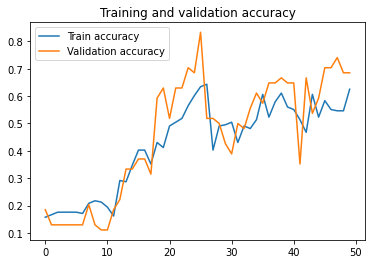

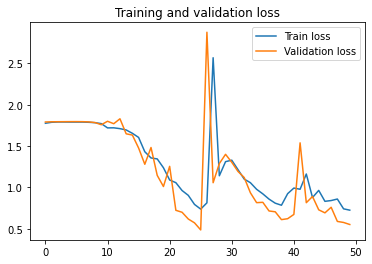

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy' ]
val_acc  = history.history['val_accuracy' ]
loss     = history.history['loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc , label='Train accuracy')
plt.plot  ( epochs, val_acc , label='Validation accuracy')
plt.legend()
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss , label='Train loss')
plt.plot  ( epochs, val_loss , label='Validation loss')
plt.legend()
plt.title ('Training and validation loss'   )

In [ ]:
tf.keras.models.save_model(model, "motion.h5", include_optimizer=False)

In [ ]:
model2 = tf.keras.models.load_model("motion.h5")

In [48]:
model.predict_classes(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [49]:
model2.predict_classes(X_test)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

# Live test here

In [ ]:
# For webcam input:
single_data = []
is_record = True
duration = 0
start = 0
count = 0
image_count = 0
pred_text = ''
outcome = ''
prob = ''
font = cv2.FONT_HERSHEY_SIMPLEX 
cap = cv2.VideoCapture(0)


# Timer 
start = time.time()
wait_start = time.time()
with mp_hands.Hands(
        min_detection_confidence=0.7,
        min_tracking_confidence=0.9) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        results = hands.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        k = cv2.waitKey(1)   
        if k % 256 == 32:
            # SPACE pressed
            is_record = True
            duration = 0
            count = 0
            print('Start recording')

        # Create a dalay of 0.5 to 1 second for re position the hand for next sign
        wait_end = time.time()
        if (wait_end-wait_start) > 1:
            is_record = True
            
        
        if is_record:
            
#             img_name = file_path + SIGN + str(img_counter) + name + '.jpg'
#             print(img_name)
            # Capture 10 frame 
            cv2.imwrite('image.jpg', image)
            end = time.time()
            duration = end - start
            #take a pic per 0.1 second
            if(duration>(0.1)):
                start = time.time()
                if not results.multi_hand_landmarks == None:
                    count += 1
                    temp= [] 
                    for cords in results.multi_hand_landmarks[0].landmark:
                        temp.append([cords.x,cords.y,cords.z])
                    single_data.append(temp)
    
                if count >= 10:
                    # take the last 10 frame
                    pre_x = np.array(single_data[-10:]).reshape((1,10, 21, 3))
                    pred = model.predict(pre_x)[0]
                    prob = pred[np.argmax(pred)]
                    outcome = le.classes_[np.argmax(pred)]
                    single_data = []
                    # set False to enable wait 
                    is_record = False
                    wait_start = time.time()
                    count = -5

        pred_text = str(outcome) +', '+ str(prob)+ ' ' +str(count)
#             time.sleep(0.1)


        cv2.putText(image,  pred_text,  (50, 80),  font, 0.75,  (0, 255, 255),  2,  cv2.LINE_4)       
        cv2.imshow('MediaPipe Hands', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
cap.release()